<a href="https://colab.research.google.com/github/letianzj/QuantResearch/blob/master/ml/atari_space_invaders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(Use Open in Colab button above to watch the embedded videos of agent playing Space-Invader)

## Introduction

[OpenAI Gym](https://gym.openai.com/) provides a list of test environments to help develop reinforcement learning algorithms. This [leaderboard](https://github.com/cshenton/atari-leaderboard) keeps records from both human and machine players.

A gym environment is a __Markov Decision Process__ of tuple $<S, A, P, R, \gamma>$ that includes the following.
* **Agent** -- The robot player to be trained.
* **Environment** -- Atari game.
* **observation space** -- The current state of the environment that the robot observes.
* **action space** -- The choice that the robot takes at each step.
* **Reward** -- Game score.
* **Policy** -- How the robot plays.

This notebook illustrates how to train [Atari Space-Invaders](https://gym.openai.com/envs/SpaceInvaders-v0/) using [TF-Agents](https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial). It follows the official [TF-Agents DQN Tutorial](https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial) and [Hands-on Machine Learning by Aurélien Géron 2019](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/).

## Setup

Install required packages and Roms.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/usr/bin/python3
3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0)


1.1 Install required packages. Uncomment to execute once.

In [ ]:
# !sudo apt-get update
# !sudo apt-get install -y xvfb ffmpeg freeglut3-dev
# !pip install -q 'gym==0.16.0'
# !pip install 'imageio==2.4.0'
# !pip install pyvirtualdisplay
# !pip install tf-agents[reverb]
# !pip install pyglet
# !pip install ale-py

1.2. Install Atari Roms to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/. Uncomment to execute once.

In [ ]:
# !wget http://www.atarimania.com/roms/Roms.rar
# !pip install unrar
# !unrar x Roms.rar
# !mkdir rars
# !mv HC\ ROMS.zip  rars
# !mv ROMS.zip  rars
# !python -m atari_py.import_roms rars

1.3. Import packages. Sometimes it has to run twice.

In [ ]:
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb

import gym
import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver
from tf_agents.environments import suite_gym, suite_atari
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential, q_network, network
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import TFUniformReplayBuffer
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

In [ ]:
gym.__version__

'0.21.0'

In [ ]:
# list available environments
# print(gym.envs.registry.all())

Setup virtual display and helper class

In [ ]:
# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

def create_policy_eval_video(policy, filename, num_episodes=5, fps=30, max_steps=-1):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      n_step = 0
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
        n_step += 1
        if (n_step > max_steps) & (max_steps > 0):
          break
  return embed_mp4(filename)

## Environment

Load Atari Environment

In [ ]:
#env_name = 'BreakoutNoFrameskip-v4'
env_name = 'SpaceInvaders-v0'
env = suite_gym.load(env_name)

This is how the game looks like.

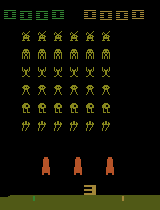

In [ ]:
env.reset()
PIL.Image.fromarray(env.render())

In [ ]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255)


In [ ]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [ ]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=5)


In [ ]:
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

In the Atari Space_Invaders environment, the agent learns to control a laser cannon to fire at descending aliens. The goal is to defeat all the aliens while avoiding to be destroyed by them.

* Observation has a shape of (210, 160, 3), which stands for 210 pixels long, 160 pixels wide, and RGB color channels. Each chanel is an integer value from 0 to 255. For example, a black pixel is (0,0,0), a white pixel is (255, 255, 255).
* Reward is a scalar float value. Total rewards is the game score. No discount.
* Action is a scalar integer with six possible values:
  * 0 — Stand still
  * 1 — Fire
  * 2 -- Move Right
  * 3 -- Move Left
  * 4 -- Move Right and Fire
  * 5 -- Move Left and Fire

After we take an action, the environment moves to the next time step.

In [ ]:
time_step = env.reset()
print('Time step:')
print(time_step.observation.shape)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step.observation.shape)

Time step:
(210, 160, 3)
Next time step:
(210, 160, 3)


The first thing is to pre-process or downsample the game screen. TF-Agents offers standard image preprocessing as
* Frame skipping (defaults to 4).
* Terminal signal when a life is lost (off by default).
* Grayscale and max-pooling of the last two frames.
* Downsample the screen to a square image (defaults to 84x84).
* Frame stacking to tell the direction and speed of the ball.

In [ ]:
ATARI_FRAME_SKIP = 4
max_episode_frames = ATARI_FRAME_SKIP * 50_000

train_py_env = suite_atari.load(
    env_name,
    max_episode_steps=max_episode_frames / ATARI_FRAME_SKIP,
    gym_env_wrappers=suite_atari.DEFAULT_ATARI_GYM_WRAPPERS_WITH_STACKING)
eval_py_env = suite_atari.load(
    env_name,
    max_episode_steps=max_episode_frames / ATARI_FRAME_SKIP,
    gym_env_wrappers=suite_atari.DEFAULT_ATARI_GYM_WRAPPERS_WITH_STACKING)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

Taste the game environment with a random policy. It does not play well.

The random policy is like an infant, who plays with the joystick and does meaningless moves. The remainder of the notebook is to train her how to play the game. Come back and compare with this moment to see how she grows.

In [ ]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(), train_env.action_spec())

In [ ]:
create_policy_eval_video(random_policy, "random-agent", num_episodes=1)

## Agent

It defines the DQN agent to be trained.

At the heart of a DQN Agent is a `QNetwork`, a neural network model that can learn to predict `QValues` (expected returns) for all actions, given an observation from the environment.

The QNet is a convolutional neural network (CNN) illustrated as below.

![DQN](https://leonardoaraujosantos.gitbook.io/~/files/v0/b/gitbook-28427.appspot.com/o/assets%2F-LvMRntv-nKvtl7WOpCz%2F-LvMRp9FltcwEeVxPYFs%2F-LvMRsnabIKrofQLFbYP%2FDQNBreakoutBlocks.png?generation=1575572714769936&alt=media)

[Figure source](https://leonardoaraujosantos.gitbook.io/artificial-inteligence/)



CNN is widely used in image recognition. Here the game screen has a shape of (210, 160, 3), which stands for 210 pixels long, 160 pixels wide, and RGB color channels. DQN downsamples the pixel to 84 x 84 and convert the RGB colors to grayscale. Then it stacks 4 frames together in order to tell the direction and velocity of moving objects. Therefore the input is 84x84x4.

In [ ]:
train_py_env.observation_spec().shape        # (84x84) x 4 frames

(84, 84, 4)

In [ ]:
# https://keras.io/examples/rl/deep_q_network_breakout/
# Define a Q network with three convolutional layers and a fully connected layer
action_tensor_spec = tensor_spec.from_spec(train_env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1
observation_spec = tensor_spec.from_spec(train_env.observation_spec())    # (84, 84, 4) four gray frames stacking       

# preprocessing from uint8 color code between 0 and 255 to a float32 between 0 and 1.
layer0 = tf.keras.layers.Lambda(lambda obs: tf.cast(obs, np.float32) / 255.)
layer1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(8, 8), strides = (4, 4), activation='relu')
layer2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(4, 4), strides = (2, 2), activation='relu')
layer3 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides = (1, 1), activation='relu')
layer4 = tf.keras.layers.Flatten()
layer5 = tf.keras.layers.Dense(512, activation='relu')
layer6 = tf.keras.layers.Dense(num_actions, activation='linear') # action layer

q_net = sequential.Sequential([layer0, layer1, layer2, layer3, layer4, layer5, layer6])

In [ ]:
q_net.build(input_shape=observation_spec.shape)
q_net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              multiple                  0 (unused)
_________________________________________________________________
conv2d (Conv2D)              multiple                  0 (unused)
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  0 (unused)
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  0 (unused)
_________________________________________________________________
flatten (Flatten)            multiple                  0 (unused)
_________________________________________________________________
dense (Dense)                multiple                  0 (unused)
_________________________________________________________________
dense_1 (Dense)              multiple                  0

Now use `tf_agents.agents.dqn.dqn_agent` to instantiate a `DqnAgent`. In addition to the `time_step_spec`, `action_spec` and the QNetwork, the agent constructor also requires an optimizer, a loss function, and an integer step counter.

The hyper-parameters follow [Hands-on Machine Learning by Aurélien Géron 2019](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/).

In [ ]:
global_step = tf.compat.v1.train.get_or_create_global_step()
#train_step = tf.Variable(0)
update_period = 4 # train the model every 4 steps
optimizer = tf.keras.optimizers.RMSprop(lr=2.5e-4, rho=0.95, momentum=0.0,
                                     epsilon=0.00001, centered=True)
epsilon_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0, # initial ε
    decay_steps=250000 // update_period, # <=> 1,000,000 ALE frames
    end_learning_rate=0.01) # final ε
agent = dqn_agent.DqnAgent(train_env.time_step_spec(),
                           train_env.action_spec(),
                           q_network=q_net,
                           optimizer=optimizer,
                           target_update_period=2000, # <=> 32,000 ALE frames
                           td_errors_loss_fn=tf.keras.losses.Huber(reduction="none"),
                           gamma=0.99, # discount factor
                           train_step_counter=global_step,
                           epsilon_greedy=lambda: epsilon_fn(global_step))
agent.initialize()

Agents contain two policies:

* agent.policy — The main policy that is used for evaluation and deployment.
* agent.collect_policy — A second policy that is used for data collection.

## Metrics

The most common metric used to evaluate a policy is the average return. The return is the sum of rewards obtained while running a policy in an environment for an episode. Several episodes are run, creating an average return.

The following function computes the average return of a policy, given the policy, environment, and a number of episodes.

In [ ]:
def compute_avg_return(environment, policy, num_episodes=10, max_steps=-1):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0
    n_step = 0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
      n_step += 1
      if (n_step > max_steps) & (max_steps > 0):
        break
    
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

Running this computation on the `random_policy` shows a baseline performance in the environment.

In [ ]:
num_eval_episodes = 5
compute_avg_return(eval_env, random_policy, num_eval_episodes)

171.0

## Replay Buffer

One original design of DQN is replay buffer. It collects the experience or transition tuple $(s, a, s', r)$ from not only current policy but also other policies. It then takes random mini-batches from the buffer.

Replay buffer in TF-Agents consists of below components.
1. driver -- explores the environment using a collect policy
2. collect policy -- used by driver to interact with the environment
3. observer -- receives trajectories or experiences from driver and save to replay buffer
4. agent -- randomly pull experience from replay buffer and use the experience to train



In [ ]:
replay_buffer = TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=100_000)

In [ ]:
replay_buffer_observer = replay_buffer.add_batch

To start, initialize the replay buffer with some random experiences. The replay buffer is FIFO. As new experiences arrive, they will overwrite old experiences.

It takes a couple of minutes to fill 20,000 steps.

In [ ]:
train_env.reset()

init_driver = DynamicStepDriver(
    train_env,
    random_policy,
    observers=[replay_buffer.add_batch],
    num_steps=20_000) # <=> 80,000 ALE frames
final_time_step, final_policy_state = init_driver.run()

For information purposes, sample a batch of trajectories from the replay buffer and examine how they look like.

Below it samples 2 trajectories; each has three steps; each step contains a 84x84x4 observation.

In [ ]:
trajectories, buffer_info = replay_buffer.get_next(sample_batch_size=2, num_steps=3)

In [ ]:
trajectories.observation.shape

TensorShape([2, 3, 84, 84, 4])

In [ ]:
from tf_agents.trajectories.trajectory import to_transition
time_steps, action_steps, next_time_steps = to_transition(trajectories)
time_steps.observation.shape

TensorShape([2, 2, 84, 84, 4])

The agent needs access to the replay buffer. This is provided by creating an iterable tf.data.Dataset pipeline which will feed data to the agent.

Each row of the replay buffer only stores a single observation step. But since the DQN Agent needs both the current and next observation to compute the loss, the dataset pipeline will sample two adjacent rows for each item in the batch (`num_steps=2`).

In [ ]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=32,
    num_steps=2).prefetch(3)

In [ ]:
iterator = iter(dataset)

## Training the agent

Now it is ready to train the agent. 

Set num_iterations to 5_000 for testing. 1_000_000 takes days.

[Save Model](https://www.tensorflow.org/agents/tutorials/10_checkpointer_policysaver_tutorial)

[Colab timeout](https://research.google.com/colaboratory/faq.html#idle-timeouts)

It needs to periodically save the model in order to continue the training process after Colab disconnection. To save and reload agent status, including replay buffer, use Checkpointer.

In the end, we can just save the policy using PolicySaver.

In [ ]:
num_iterations = 100_000   # less intelligence, more persistance; 24x7 player
save_interval = 100_000
eval_interval = 50_000
log_interval = 5_000

In [ ]:
# Create a driver to collect experience.
collect_driver = DynamicStepDriver(
    train_env,
    agent.collect_policy,
    observers=[replay_buffer_observer],
    num_steps=update_period) # collect 4 steps for each training iteration

In [ ]:
#from tf_agents.policies import PolicySaver
import os
import io
import tempfile
import shutil
import zipfile
import numpy as np
from google.colab import files

tempdir = os.getenv("TEST_TMPDIR", tempfile.gettempdir())

In [ ]:
def create_zip_file(dirname, base_filename):
  return shutil.make_archive(base_filename, 'zip', dirname)

def save_checkpoint_to_local():
  train_checkpointer.save(global_step)
  # add returns to checkpoint_dir
  np.savetxt(os.path.join(checkpoint_dir, 'returns.txt'), returns, delimiter=',')
  checkpoint_zip_filename = create_zip_file(checkpoint_dir, os.path.join(tempdir, 'exported_cp'))
  # Privacy and security -> Site Settings -> Automatic downloads
  files.download(checkpoint_zip_filename) # try again if this fails: https://github.com/googlecolab/colabtools/issues/469

def upload_and_unzip_file_to(dirname):
  if files is None:
    return
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    shutil.rmtree(dirname)
    zip_files = zipfile.ZipFile(io.BytesIO(uploaded[fn]), 'r')
    zip_files.extractall(dirname)
    zip_files.close()

In [ ]:
checkpoint_dir = os.path.join(tempdir, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer,
    global_step=global_step
)

To [keep Colab running](https://stackoverflow.com/questions/57113226/how-to-prevent-google-colab-from-disconnecting).

function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}

var colab = setInterval(ConnectButton,60000);
clearInterval(colab)

In [ ]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
collect_driver.run = common.function(collect_driver.run)
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = np.array([avg_return])

# Reset the environment.
time_step = None
policy_state = agent.collect_policy.get_initial_state(train_env.batch_size)

step = 0
while True:
    # Collect a few steps using collect_policy and save to the replay buffer.
    time_step, policy_state = collect_driver.run(time_step, policy_state)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()
    print(f'\r step {step}', end='')

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns = np.append(returns, avg_return)

    # if step % save_interval == 0:
    #     save_checkpoint_to_local()

    if step > num_iterations:
        break

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


 step 5000step = 5000: loss = 0.608530580997467
 step 10000step = 10000: loss = 1.491654396057129
 step 15000step = 15000: loss = 1.0811423063278198
 step 20000step = 20000: loss = 0.04874517768621445
 step 25000step = 25000: loss = 1.1065270900726318
 step 30000step = 30000: loss = 0.08628454804420471
 step 35000step = 35000: loss = 0.7659016847610474
 step 40000step = 40000: loss = 1.0400705337524414
 step 45000step = 45000: loss = 2.0612244606018066
 step 50000step = 50000: loss = 0.8223446607589722
step = 50000: Average Return = 245.0
 step 55000step = 55000: loss = 1.7679486274719238
 step 60000step = 60000: loss = 1.2738096714019775
 step 65000step = 65000: loss = 2.466463565826416
 step 70000step = 70000: loss = 0.8637232780456543
 step 75000step = 75000: loss = 2.239035129547119
 step 80000step = 80000: loss = 0.8663248419761658
 step 85000step = 85000: loss = 1.6288963556289673
 step 90000step = 90000: loss = 3.173646926879883
 step 95000step = 95000: loss = 1.4633464813232422

In [ ]:
save_checkpoint_to_local()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Upload and continue after Colab is disconnected.

In [ ]:
!mkdir -p $checkpoint_dir

In [ ]:
upload_and_unzip_file_to(checkpoint_dir)
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()
returns = np.loadtxt(os.path.join(checkpoint_dir, 'returns.txt'), delimiter=',', dtype=np.float32)

remove uploaded file

In [ ]:
!rm exported_cp.zip

Continue the training. 

In [ ]:
num_iterations = 200_000          # increase 100_000 each time, to 1_000_0000

In [ ]:
while True:
    # Collect a few steps using collect_policy and save to the replay buffer.
    time_step, policy_state = collect_driver.run(time_step, policy_state)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()
    print(f'\r step {step}', end='')

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns = np.append(returns, avg_return)

    # if step % save_interval == 0:
    #     save_checkpoint_to_local()

    if step > num_iterations:
        break

 step 105000step = 105000: loss = 1.713509440422058
 step 110000step = 110000: loss = 4.5312604904174805
 step 115000step = 115000: loss = 2.102066993713379
 step 120000step = 120000: loss = 3.047064781188965
 step 125000step = 125000: loss = 2.2205536365509033
 step 130000step = 130000: loss = 3.136992931365967
 step 135000step = 135000: loss = 8.079166412353516
 step 140000step = 140000: loss = 1.7076475620269775
 step 145000step = 145000: loss = 1.7515592575073242
 step 150000step = 150000: loss = 2.315495252609253
step = 150000: Average Return = 493.0
 step 155000step = 155000: loss = 2.5497970581054688
 step 160000step = 160000: loss = 3.640261173248291
 step 165000step = 165000: loss = 2.2458770275115967
 step 170000step = 170000: loss = 3.233553409576416
 step 175000step = 175000: loss = 5.8226704597473145
 step 180000step = 180000: loss = 3.067084789276123
 step 185000step = 185000: loss = 2.470966339111328
 step 190000step = 190000: loss = 3.1095316410064697
 step 195000step =

In [ ]:
save_checkpoint_to_local()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In the end, save the lightweighted policy to play the game.

In [ ]:
from tf_agents.policies import policy_saver

policy_dir = os.path.join(tempdir, 'policy')
tf_policy_saver = policy_saver.PolicySaver(agent.policy)

tf_policy_saver.save(policy_dir)
policy_zip_filename = create_zip_file(policy_dir, os.path.join(tempdir, 'exported_policy'))

INFO:tensorflow:Assets written to: /tmp/policy/assets


INFO:tensorflow:Assets written to: /tmp/policy/assets


In [ ]:
files.download(policy_zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Evaluation

Load the trained policy and saved average return.

A trained policy is saved at https://github.com/letianzj/QuantResearch/blob/master/ml/atari_policy.zip

In [ ]:
# upload_and_unzip_file_to(policy_dir)       # wget from github and unzip
# saved_policy = tf.saved_model.load(policy_dir)

The average return is expected to increase over training iterations.

Here num_iterations = 200_000; eval_interval = 50_000.

(232.6, 550.0)

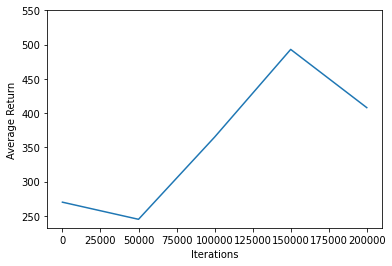

In [ ]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=550)

See how the trained agent plays.

In [ ]:
create_policy_eval_video(agent.policy, "trained-agent", num_episodes=1)